In [1]:
import logging
import os

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro

smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.8.1')

pyro.enable_validation(True)
pyro.set_rng_seed(1)
logging.basicConfig(format='%(message)s', level=logging.INFO)

# Set matplotlib settings
%matplotlib inline
plt.style.use('default')

# Univariate Gaussian

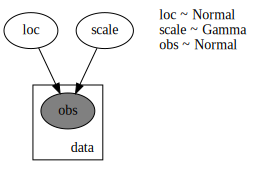

In [491]:
import pyro.distributions as dist
import pyro.distributions.constraints as constraints

loc = 5
scale = 20
data = torch.tensor(np.random.normal(loc=loc, scale=scale, size=1000))

loc = 5
scale = 20
data = torch.tensor(np.random.normal(loc=loc, scale=scale, size=1000))

def model(loc_prior_params, scale_prior_params, data):
    loc = pyro.sample("loc", dist.Normal(loc_prior_params[0], loc_prior_params[1]))
    scale = pyro.sample("scale", dist.Gamma(scale_prior_params[0], scale_prior_params[1]))
    with pyro.plate("data", 1000):
        return pyro.sample("obs", dist.Normal(loc, scale), obs=data)

pyro.render_model(model, model_args=([0.,4.], [1., 8.], data), render_params=True, render_distributions=True)

In [495]:
def parametrised_guide(loc_prior_params, scale_prior_params, data):
    mu_mu = pyro.param("mu_mu", torch.tensor(float(loc_prior_params[0])))
    
    mu_std = pyro.param(
        "mu_std", torch.tensor(float(loc_prior_params[1])), constraint=constraints.positive
    )
    
    std_a = pyro.param(
        "std_a", torch.tensor(scale_prior_params[0]), constraint=constraints.positive
    )
    
    std_b = pyro.param(
        "std_b", torch.tensor(scale_prior_params[1]), constraint=constraints.positive
    )

    loc = pyro.sample("loc", dist.Normal(mu_mu, mu_std))
    scale = pyro.sample("scale", dist.Normal(std_a, std_b))
    return pyro.sample("data_dist", dist.Normal(loc, scale))

### Train

Elbo loss: 6002.062380670757
Elbo loss: 4408.005375404212
Elbo loss: 4412.760751209064
Elbo loss: 4435.329954531795
Elbo loss: 4412.283470612083
Elbo loss: 4410.790958301619
Elbo loss: 4411.465558459133
Elbo loss: 4409.864568642484
Elbo loss: 4409.904160531922
Elbo loss: 4409.659610685732
Elbo loss: 4409.594549289826
Elbo loss: 4410.138656561424
Elbo loss: 4408.255383357426
Elbo loss: 4408.520574588528
Elbo loss: 4410.919180886525
Elbo loss: 4409.92616063037
Elbo loss: 4406.570965437041
Elbo loss: 4410.435982918384
Elbo loss: 4410.761380097741
Elbo loss: 4409.864142091561
Elbo loss: 4407.334233983667
Elbo loss: 4410.005377615111
Elbo loss: 4409.928895782798
Elbo loss: 4409.456223617809
Elbo loss: 4410.526812280386
Elbo loss: 4408.655772034543
Elbo loss: 4410.284092980646
Elbo loss: 4411.810813816969
Elbo loss: 4412.566431763144
Elbo loss: 4411.889129715077
Elbo loss: 4411.402322928992
Elbo loss: 4410.459156421946
Elbo loss: 4410.32480827866
Elbo loss: 4410.995585988804
Elbo loss: 4411.

CPU times: total: 18.6 s
Wall time: 19.1 s


Text(0, 0.5, 'ELBO loss')

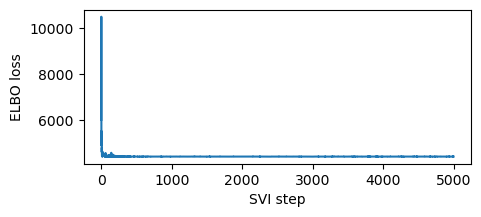

In [496]:
%%time
pyro.clear_param_store()

# These should be reset each training loop.
svi = pyro.infer.SVI(
    model=model,
    guide=parametrised_guide,
    optim=pyro.optim.Adam({"lr": 0.1}),
    loss=pyro.infer.Trace_ELBO())

losses = []
for step in range(1000 if not smoke_test else 2):  # Consider running for more steps.
    loss = svi.step([0,10], [8, 1], data)
    losses.append(loss)
    if step % 100 == 0:
        logging.info("Elbo loss: {}".format(loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

In [497]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

mu_mu 4.288233
mu_std 0.62139475
std_a 18.991621
std_b 0.45059386
